# **Result Analysis -** Godot Navigation : Simpletown

___
___

### **0. Environments & Datasets**

#### A. Amazeville Maze Layouts

| Level | Maze 1 | Maze 2 | Maze 3 | Maze 4 |
|---|---|---|---|---|
| **High Blocks (No Jump)** | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_1_up.png" width="180px" alt="Amazeville Maze 1 High" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_2_up.png" width="180px" alt="Amazeville Maze 2 High" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_3_up.png" width="180px" alt="Amazeville Maze 3 High" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_4_up.png" width="180px" alt="Amazeville Maze 4 High" /> |
| **Low Blocks (Jump)** | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_1_up.png" width="180px" alt="Amazeville Maze 1 Low" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_2_up.png" width="180px" alt="Amazeville Maze 2 Low" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_3_up.png" width="180px" alt="Amazeville Maze 3 Low" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_4_up.png" width="180px" alt="Amazeville Maze 4 Low" /> |

#### B. Amazeville Example Trajectories

| Level | Maze 1 | Maze 2 | Maze 3 | Maze 4 |
|---|---|---|---|---|
| **High Blocks (No Jump)** | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_1.gif" width="180px" alt="Amazeville Maze 1 High GIF" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_2.gif" width="180px" alt="Amazeville Maze 2 High GIF" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_3.gif" width="180px" alt="Amazeville Maze 3 High GIF" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_high_4.gif" width="180px" alt="Amazeville Maze 4 High GIF" /> |
| **Low Blocks (Jump)** | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_1.gif" width="180px" alt="Amazeville Maze 1 Low GIF" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_2.gif" width="180px" alt="Amazeville Maze 2 Low GIF" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_3.gif" width="180px" alt="Amazeville Maze 3 Low GIF" /> | <img src="../../../assets/environments/godot_goal/amazeville/amazeville_low_4.gif" width="180px" alt="Amazeville Maze 4 Low GIF" /> |

The mazes have two levels: **high** and **low**. There are four different maze layouts. In Amazeville, some mazes require jumping while others don't, and there are different paths to consider. All trajectories are human-generated.

___

### **1. Initialization**

#### *1.A. Imports*

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import seaborn as sns

from offbench.utils.logger import extract_metrics_from_event_file
from offbench.utils.paths import WORKSPACE_PATH
from hydra import compose, initialize
from omegaconf import DictConfig
from typing import Union

#### *1.B. Data*

In [2]:
all_experiments_folder_path = os.path.join(WORKSPACE_PATH, "experiments", "1_singletask", "godot_goal")

seeds = [100 * i for i in range(1, 11)]

env_name = "amazeville"

env_name_to_title = {"amazeville": "AmazeVille"}

mazes = [f"maze_{i}" for i in range(1,5)]

levels = ["low", "high"]

maze_to_title = {f"maze_{i}": f"Maze {i}" for i in range(8)}

level_to_title = {"high": "High", "low": "Low"}

agent_ids = [
    "gcbc_base_mlp",
    "hgcbc_base_mlp",
]

agent_id_to_algo = {
    "gcbc_base_mlp": "GCBC",
    "hgcbc_base_mlp": "HGCBC"
}

In [3]:
performances = []

for maze in mazes:

    for level in levels:
            
        for agent_id in agent_ids:
            
            for seed in seeds:

                experiment_folder_path = os.path.join(all_experiments_folder_path, env_name + "-" + maze + "-" + level, agent_id, f"seed_{seed}")
                path_to_logs = os.path.join(experiment_folder_path, "logs")

                if not os.path.exists(path_to_logs): continue

                events_files = os.listdir(path_to_logs)
                events_files = [f for f in events_files if "events.out.tfevents" in f]

                all_metrics = []

                for events_file in events_files:

                    metrics = extract_metrics_from_event_file(path_to_logs + "/" + events_file)

                    for tag,step,value in metrics:
                        if tag.startswith("EVALUATION"):
                            all_metrics.append({
                                "maze": maze,
                                "level": level,
                                "algo": agent_id_to_algo[agent_id],
                                "seed": seed,
                                "metric": tag.split("/")[-1],
                                "value": value,
                                "gradient_step": step,
                            })
                    
                    try:
                    
                        df = pd.DataFrame(all_metrics)
                        df = df.pivot_table(index=["maze","level","algo","seed","gradient_step"],columns="metric",values="value")
                        df = df.reset_index(drop=False)
                    
                    except:

                        print(f"Error with {experiment_folder_path}")
                    
                    performances.append(df)

performances = pd.concat(performances)
performances = performances.reset_index(drop=True)
performances = performances.rename(columns={"mean_discounted_return": "discounted_return"})
performances = performances.rename(columns={"mean_length": "length"})
performances = performances.rename(columns={"mean_success": "success"})
performances = performances.rename(columns={"mean_undiscounted_return": "undiscounted_return"})

___

### **2. Tables**

In [21]:
# keep last evaluation (for last gradient step)
performances_table = performances[performances["gradient_step"] == 200000]
performances_table = performances_table[["maze","level","algo","success","length","seed"]]

# average over seeds
performances_table = performances_table.groupby(["maze", "level","algo"]).agg(
    mean_success=("success","mean"),
    std_success=("success","std"),
    mean_length=("length","mean"),
    std_length=("length","std")
).reset_index(drop=False)
performances_table = performances_table.rename(columns={
    "mean_success": "score", 
    "std_success": "std_score",
    "mean_length": "length",
    "std_length": "std_length"
})

# put it all niceley
performances_table = performances_table.pivot_table(index=["level","maze"],columns="algo",values=["score","std_score","length","std_length"])
performances_table = performances_table[["score","std_score","length","std_length"]]
# round score
performances_table["score"] = (100 * performances_table["score"]).round(1)
performances_table["std_score"] = (100 * performances_table["std_score"]).round(1)
# round length
performances_table["length"] = performances_table["length"].round(1)
performances_table["std_length"] = performances_table["std_length"].round(1)
# sort columns
performances_table = performances_table.swaplevel(axis=1)
performances_table = performances_table.loc[levels]
performances_table = performances_table.swaplevel(axis=0)
performances_table = performances_table.loc[mazes]

In [19]:
performances_table

algo          GCBC HGCBC      GCBC     HGCBC   GCBC  HGCBC       GCBC  \
             score score std_score std_score length length std_length   
maze   level                                                            
maze_1 low    92.7  88.5       3.8       3.0  138.0  142.0        5.0   
       high   80.2  91.3       3.2       3.3  193.4  173.5        6.8   
maze_2 low    85.5  82.7       7.9       5.7  171.8  173.0       12.6   
       high   73.2  78.1       7.5       5.2  222.3  215.0        7.8   
maze_3 low    89.2  90.1       3.5       3.8  145.2  141.3        6.0   
       high   92.7  97.9       2.1       2.3  185.7  181.4        5.3   
maze_4 low    93.4  93.4       2.2       2.2  160.4  161.8        3.8   
       high   79.4  85.4       2.8       3.4  239.4  234.2        2.0   

algo              HGCBC  
             std_length  
maze   level             
maze_1 low          4.5  
       high         4.3  
maze_2 low          9.7  
       high         9.7  
maze_3 low          7.2  
       high         5.0  
maze_4 low          3.9  
       high         3.1

___

### **3. Plots**

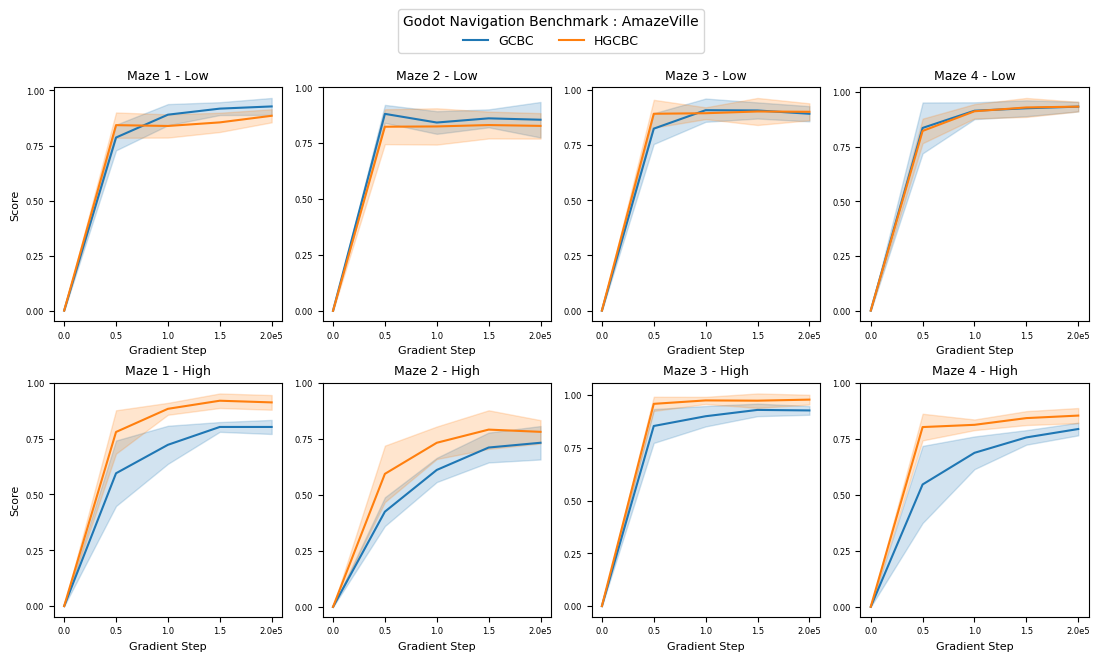

In [6]:
plt.rc('font', size=6)

fig, axes = plt.subplots(len(levels), len(mazes), figsize=(11, 6), sharex=False, sharey=False)
axes = axes if len(mazes) > 1 else [axes]

for i, level in enumerate(levels):
    for j, maze in enumerate(mazes):

        ax = axes[i, j]

        data = performances[(performances["maze"] == maze) & (performances["level"] == level)]

        sns.lineplot(
            data=data,
            x="gradient_step",
            y="success",
            hue="algo",
            ax=ax,
            errorbar="sd",
        )

        ax.set_title(f"{maze_to_title[maze]} - {level_to_title[level]}", fontsize=9)

        ax.set_xlabel("Gradient Step", fontsize=8)
        ax.set_xticks([0, 50000, 100000, 150000, 200000])
        ax.tick_params(axis='x', labelsize=6)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e5}e5' if x == 200000 else f'{x/1e5}'))

        if j == 0: ax.set_ylabel("Score", fontsize=8)
        else: ax.set_ylabel("")
        ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        ax.tick_params(axis='y', labelsize=6)

        # no legend for the moment
        ax.get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=9, title="Godot Navigation Benchmark : AmazeVille", bbox_to_anchor=(0.5, 1.095), title_fontsize=10)

plt.tight_layout()
plt.show()

___
___